In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import isodate
from datetime import datetime
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib
import shap
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('youtube_channel_real_performance_analytics.csv')
print(data.info())
print(data.isnull().sum())
display(data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364 entries, 0 to 363
Data columns (total 70 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   ID                                  364 non-null    int64  
 1   Video Duration                      364 non-null    float64
 2   Video Publish Time                  364 non-null    object 
 3   Days Since Publish                  364 non-null    int64  
 4   Day                                 364 non-null    int64  
 5   Month                               364 non-null    int64  
 6   Year                                364 non-null    int64  
 7   Day of Week                         364 non-null    object 
 8   Revenue per 1000 Views (USD)        364 non-null    float64
 9   Monetized Playbacks (Estimate)      364 non-null    float64
 10  Playback-Based CPM (USD)            364 non-null    float64
 11  CPM (USD)                           364 non-n

,ID,Video Duration,Video Publish Time,Days Since Publish,Day,Month,Year,Day of Week,Revenue per 1000 Views (USD),Monetized Playbacks (Estimate),...,Watched (Not Skipped) (%),Feed Impressions,Average View Percentage (%),Average View Duration,Views,Watch Time (hours),Subscribers,Estimated Revenue (USD),Impressions,Video Thumbnail CTR (%)
0,0,201.0,2016-06-02 00:00:00,0,2,6,2016,Thursday,0.024,723.0,...,0.0,0.0,40.38,81.0,23531.0,533.1636,51.0,0.561,41118.0,27.66
1,1,391.0,2016-06-10 00:00:00,8,10,6,2016,Friday,0.056,727.0,...,0.0,0.0,39.85,156.0,11478.0,500.5628,33.0,0.648,41627.0,5.85
2,2,133.0,2016-06-14 00:00:00,4,14,6,2016,Tuesday,0.014,76.0,...,0.0,0.0,30.88,41.0,6153.0,70.7287,8.0,0.089,38713.0,7.07
3,3,14.0,2016-06-29 00:00:00,15,29,6,2016,Wednesday,0.004,18.0,...,0.0,0.0,103.05,14.0,4398.0,17.6251,2.0,0.017,35245.0,5.60
4,4,45.0,2016-07-01 00:00:00,2,1,7,2016,Friday,0.000,0.0,...,0.0,0.0,55.70,25.0,14659.0,104.3341,28.0,0.000,46218.0,8.62


In [4]:
def parse_video_duration(x):
    if pd.isnull(x):
        return np.nan
    elif isinstance(x, (int, float)):
        return x 
    elif isinstance(x, str):
        try:
            return isodate.parse_duration(x).total_seconds()
        except:
            return np.nan
    else:
        return np.nan

In [5]:
data['Video Duration'] = data['Video Duration'].apply(parse_video_duration)
data['Video Publish Time'] = pd.to_datetime(data['Video Publish Time'])

In [6]:
data = data.dropna()
for col in ['Views', 'Estimated Revenue (USD)']:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    data = data[(data[col] >= lower) & (data[col] <= upper)]

In [11]:
data['Revenue per View'] = data['Estimated Revenue (USD)'] / data['Views']
data['Engagement Rate'] = (data['Likes'] + data['Shares'] + data['New Comments']) / data['Views'] * 100
data['Video Age (days)'] = (pd.Timestamp(datetime.now()) - data['Video Publish Time']).dt.days
data['Likes per View'] = data['Likes'] / data['Views']
data['Comments per View'] = data['New Comments'] / data['Views']
data['Shares per View'] = data['Shares'] / data['Views']
data.fillna(0, inplace=True)

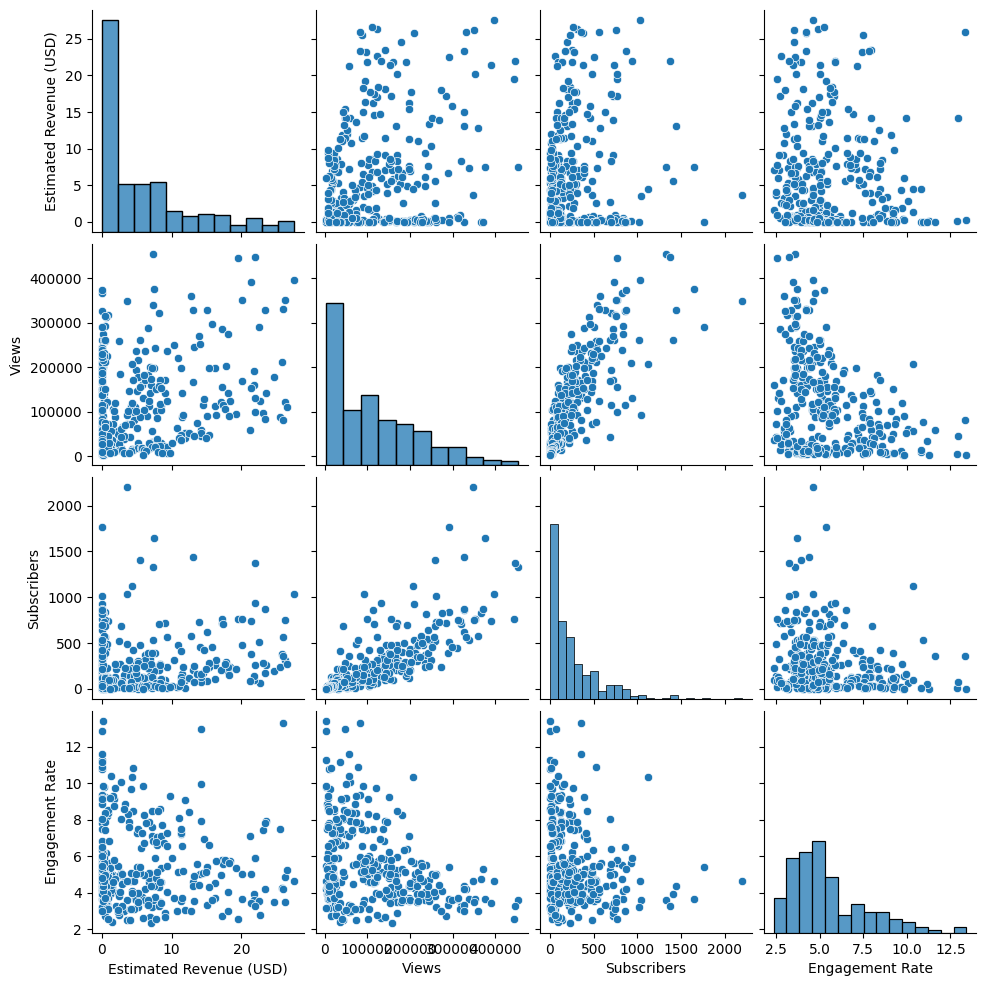

In [12]:
sns.pairplot(data[['Estimated Revenue (USD)', 'Views', 'Subscribers', 'Engagement Rate']])
plt.show()

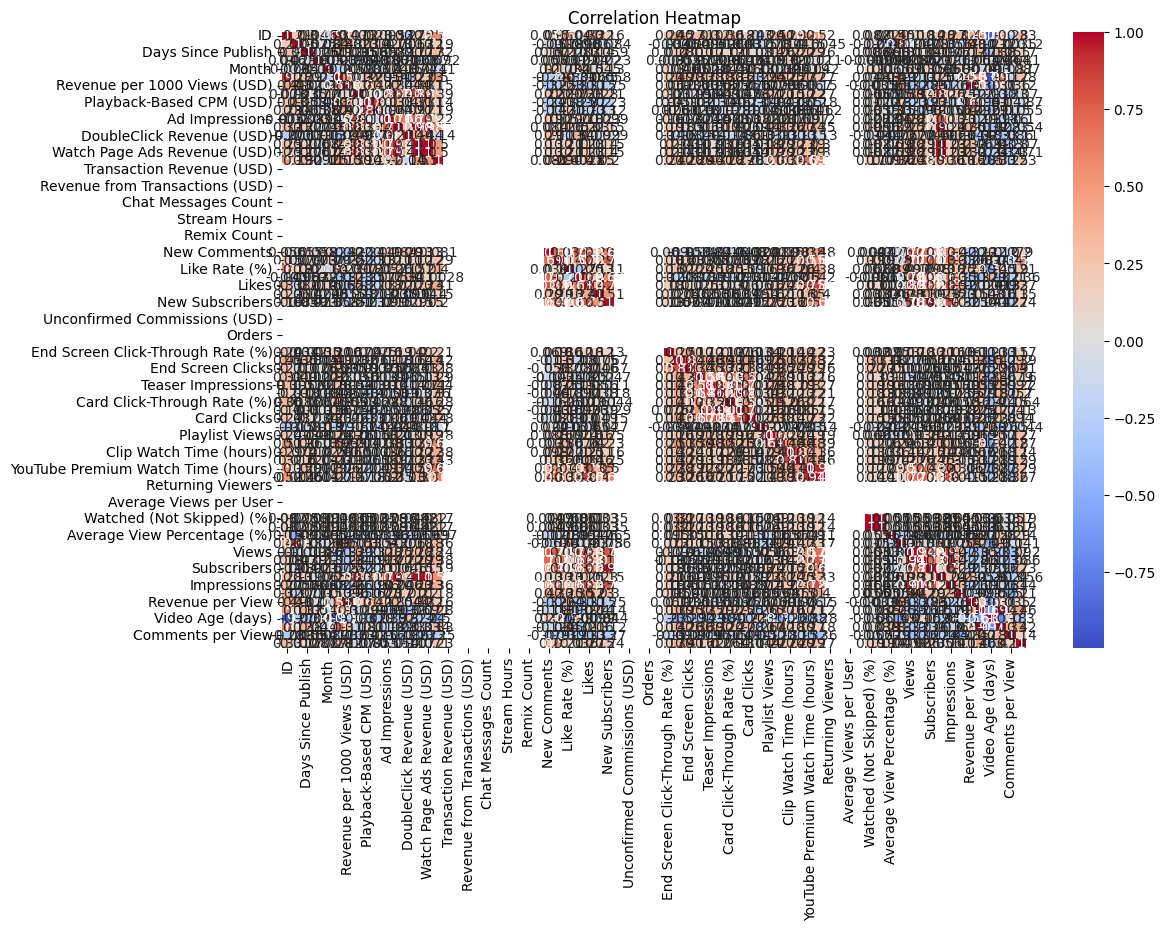

In [13]:
plt.figure(figsize=(12,8))
sns.heatmap(data.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

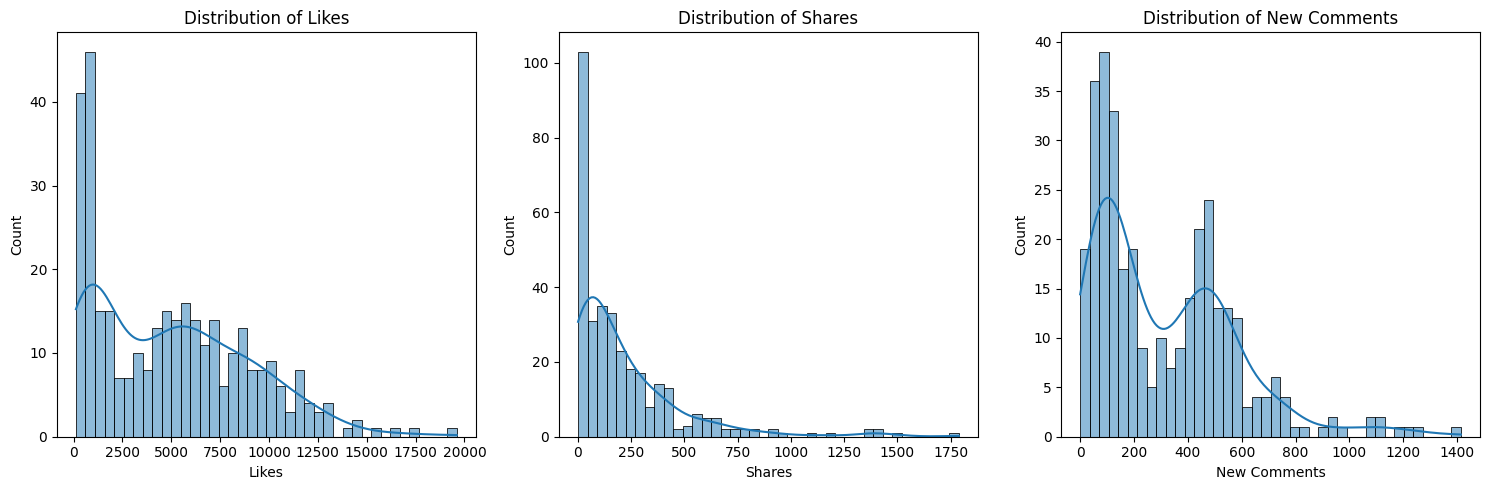

In [15]:
plt.figure(figsize=(15,5))
for i, col in enumerate(['Likes', 'Shares', 'New Comments']):
    plt.subplot(1,3,i+1)
    sns.histplot(data[col], bins=40, kde=True)
    plt.title(f"Distribution of {col}")
plt.tight_layout()
plt.show()

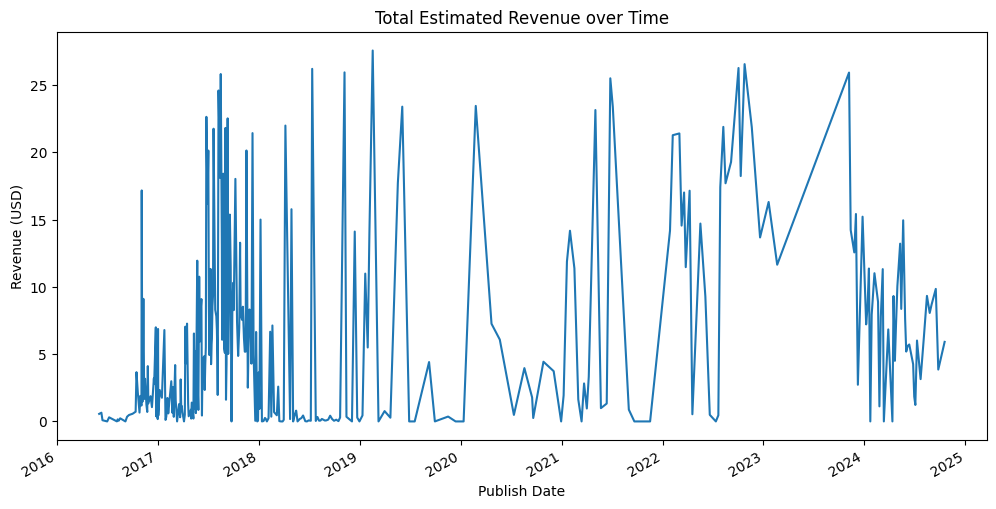

In [16]:
plt.figure(figsize=(12,6))
revenue_time = data.groupby('Video Publish Time')['Estimated Revenue (USD)'].sum()
revenue_time.plot()
plt.title("Total Estimated Revenue over Time")
plt.ylabel("Revenue (USD)")
plt.xlabel("Publish Date")
plt.show()

In [17]:
features = ['Views', 'Subscribers', 'Likes', 'Shares', 'New Comments', 'Engagement Rate', 'Video Age (days)', 'Likes per View', 'Comments per View', 'Shares per View']
target = 'Estimated Revenue (USD)'
X = data[features]
y = data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf = RandomForestRegressor(random_state=42)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}
grid_search = GridSearchCV(rf, param_grid, cv=3, n_jobs=-1, scoring='r2')
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

In [18]:
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Best params: {grid_search.best_params_}")
print(f"MSE: {mse:.2f}, RMSE: {rmse:.2f}, MAE: {mae:.2f}, R2: {r2:.2f}")

Best params: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
MSE: 20.33, RMSE: 4.51, MAE: 3.23, R2: 0.40


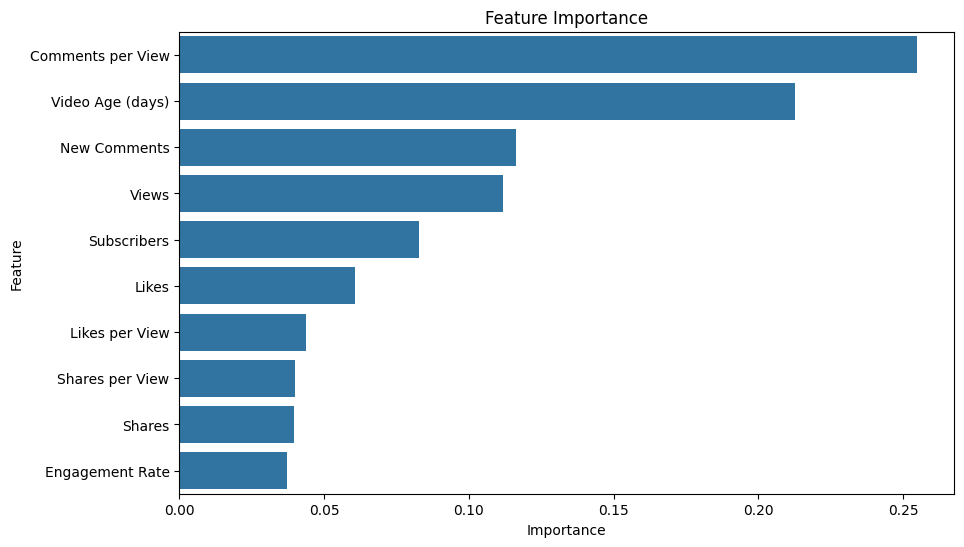

In [19]:
importances = best_model.feature_importances_
feat_imp = pd.DataFrame({'Feature': features, 'Importance': importances}).sort_values('Importance', ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=feat_imp)
plt.title("Feature Importance")
plt.show()

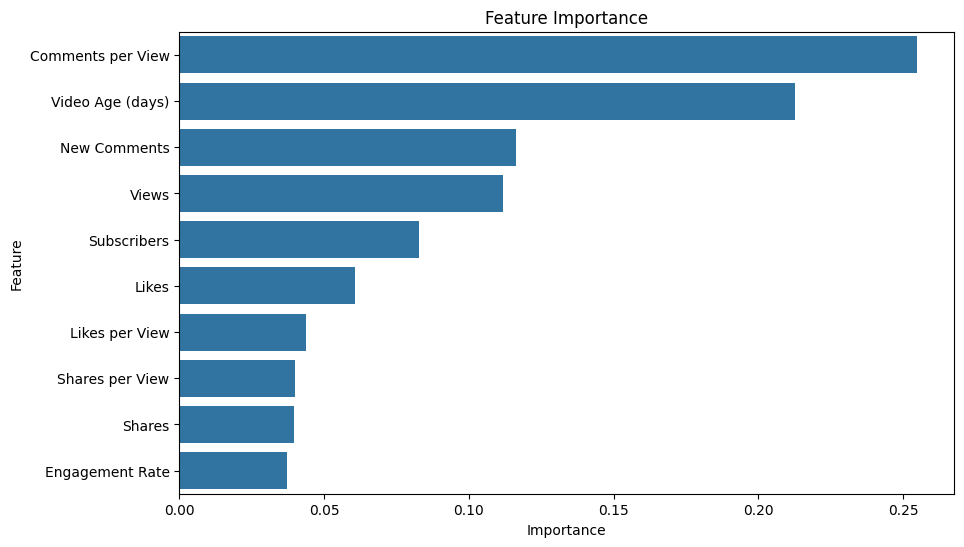

In [20]:
importances = best_model.feature_importances_
feat_imp = pd.DataFrame({'Feature': features, 'Importance': importances}).sort_values('Importance', ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=feat_imp)
plt.title("Feature Importance")
plt.show()

In [21]:
joblib.dump(best_model, 'youtube_revenue_predictor.pkl')

['youtube_revenue_predictor.pkl']